# 0. Setup.

In [4]:
# Imports.
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import import_ipynb
import methods     # for custom methods.

# Random Seed.
from transformers import set_seed
import tensorflow as tf

set_seed(42)              # For HF.
tf.random.set_seed(42)    # For tf, np, and python.

> #### Note) All defines or method is in './methods.ipynb' file.   
> These are supposed to be imported (e.g. methods.plot_learning_curve).   
> But for convenience, it is also defined in the last of 'main.ipynb', and directly used.   
> Apology for possible inconvenience, I was barely familiar with competitions :)

#### To print tables on the left, inside of the cell.

In [5]:
%%html
<style>
    table {
        float: left;
        margin-right: 20px; /* Optional: Adds space between table and other content */
    }
</style>

# 2. Preprocessing.
- Choose nonlinguistic features : **Category** and **Host**.
- Preprocess : One-hot encoding.

## 2.1. Load.

In [7]:
# Load.
from sklearn.model_selection import train_test_split
data                = pd.read_csv('./dataset/train.csv')
train_set, test_set = train_test_split(data, test_size=0.2)

label_col_idx = train_set.columns.get_loc('question_asker_intent_understanding')  # Label Columns start from it.
x_train       = train_set.iloc[:, :label_col_idx]
y_train       = train_set.iloc[:, label_col_idx:]
x_test        = test_set.iloc[:, :label_col_idx]
y_test        = test_set.iloc[:, label_col_idx:]

# Null Check.
is_null = data.isnull().values.any()
print(f'Any null values? {is_null}')

# Copy train_set for EDA. (Only if train_set < 2 GB)
train_set_size = train_set.memory_usage(deep=True).sum() / (1024 ** 3)  # In GB.

if train_set_size < 2:               
    train_cp   = train_set.copy()
    x_train_cp = x_train.copy() 
    y_train_cp = y_train.copy()
else:
    print("Train set copy failed! It's more than 2 GB!")

Any null values? False


> #### Note) Load Data with 🤗.  
> In practice, use `datasets.load_dataset()`, then `df = ds.to_pandas()`.  
> `df` loads directly to RAM, but 'ds' uses memory-mapping with disk.  
> And conversion only temporary changes the interface, not actual conversation.  
> Simply put, **it's a way more efficient.**

## 2.2. Feature Engineering.

In [8]:
# Show features.
x_train_cp.iloc[0]

qa_id                                                              1369
question_title                           Get raw output from web server
question_body         For research I am looking to get the actual ra...
question_user_name                                            beingalex
question_user_page                 https://serverfault.com/users/111705
answer                Add the --save-headers option to the wget comm...
answer_user_name                                        Michael Hampton
answer_user_page                   https://serverfault.com/users/126632
url                             http://serverfault.com/questions/430316
category                                                     TECHNOLOGY
host                                                    serverfault.com
Name: 861, dtype: object

### 2.2.1. Delete Redundant features.
- `qa_id` : Just ID of the sample.
- `question_user_name` : Not useful since it is not equal with rater.
- `question_user_page` : Same reason.
- `answer_user_name`   : For real competition, we could try to extract some info from the user page, but not for practice.
- `answer_user_page`   : Same reason.
- `url` : Same reason.

In [9]:
# Delete redundant features.
redundant_features = ['qa_id', 'question_user_name', 'question_user_page',
                      'answer_user_name', 'answer_user_page', 'url']
x_train_cp = x_train_cp.drop(columns=redundant_features)  
x_train_cp.columns

Index(['question_title', 'question_body', 'answer', 'category', 'host'], dtype='object')

### 2.2.2. Encode Categorical Columns.
- `question_title`, `question_body`, `answer` : Should remain as string.
- `category` : Only 5, let's encode.
- `host` : There are clearly dominant sources. Let's try top $n$ and else.

In [10]:
# Check the number of each class.
cols_cat = ['category', 'host']
for col in cols_cat:
    print(f'Length: {len(x_train_cp[col].value_counts())}')
    print(x_train_cp[col].value_counts()[:5], end='\n\n')

# Encode `category` and `host`.
# Find Top N hosts.
n_hosts   = 10
top_hosts = x_train_cp['host'].value_counts().nlargest(n_hosts).index

# Convert others into 'Others'.
x_train_cp['host'] = x_train_cp['host'].apply(lambda x: x if x in top_hosts else 'Others')

# One-hot Encoding.
from sklearn.preprocessing import OneHotEncoder

cols_to_enc = ['category', 'host']
one_enc     = OneHotEncoder(handle_unknown='ignore')          # Zero vector for unknown category.
x_enc       = one_enc.fit_transform(x_train_cp[cols_to_enc])

# Convert back to DataFrame.
enc_columns = one_enc.get_feature_names_out(cols_to_enc)
x_enc_df    = pd.DataFrame(x_enc.toarray(), columns=enc_columns, index=x_train_cp.index)

x_train_cp   = x_train_cp.drop(columns=cols_to_enc)           # Drop original 'category' and 'host' columns.
x_train_cp   = pd.concat([x_train_cp, x_enc_df], axis=1)      # Concatenate the encoded columns back to x_train_2.

# Result.
x_train_cp.columns

Length: 5
category
TECHNOLOGY       1947
STACKOVERFLOW    1015
CULTURE           770
SCIENCE           573
LIFE_ARTS         558
Name: count, dtype: int64

Length: 63
host
stackoverflow.com                1015
english.stackexchange.com         188
electronics.stackexchange.com     184
superuser.com                     178
serverfault.com                   175
Name: count, dtype: int64



Index(['question_title', 'question_body', 'answer', 'category_CULTURE',
       'category_LIFE_ARTS', 'category_SCIENCE', 'category_STACKOVERFLOW',
       'category_TECHNOLOGY', 'host_Others', 'host_askubuntu.com',
       'host_electronics.stackexchange.com', 'host_english.stackexchange.com',
       'host_math.stackexchange.com', 'host_physics.stackexchange.com',
       'host_rpg.stackexchange.com', 'host_serverfault.com',
       'host_stackoverflow.com', 'host_superuser.com',
       'host_tex.stackexchange.com'],
      dtype='object')

### 2.2.3. Merge txt columns.

In [11]:
# Merge sentences into one column.
cols_txt   = ['question_title', 'question_body', 'answer']
x_train_cp['txt_merged'] = x_train_cp[cols_txt].apply(lambda row: ' '.join(row), axis=1)
x_train_cp = x_train_cp.drop(columns=cols_txt)

## 2.3. Preprocessing Pipeline.

In [12]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(x_train, n_hosts=10):
    # 2.2.1. Drop redundant features.
    redundant_features   = ['qa_id', 'question_user_name', 'question_user_page', 
                            'answer_user_page', 'answer_user_name', 'url']
    x_train = x_train.drop(columns=redundant_features)

    # 2.2.2. Encode categorical features.
    # Converts other categories into 'Others'.
    top_hosts = x_train['host'].value_counts().nlargest(n_hosts).index
    x_train['host'] = x_train['host'].apply(lambda x: x if x in top_hosts else 'Others')

    # Encode `category` and `host`.
    categorical_features = ['category', 'host']
    one_enc     = OneHotEncoder(handle_unknown='ignore')    # Zero vector for unknown category.
    x_enc       = one_enc.fit_transform(x_train[categorical_features])

    # Convert back to DataFrame.
    enc_columns = one_enc.get_feature_names_out(categorical_features)
    x_enc_df    = pd.DataFrame(x_enc.toarray(), columns=enc_columns, index=x_train.index)
    x_train     = x_train.drop(columns=categorical_features)   # Drop original 'category' and 'host' columns.
    x_train     = pd.concat([x_train, x_enc_df], axis=1)       # Concatenate the encoded columns back.

    # 2.2.3. Merge txt columns.
    cols_txt = ['question_title', 'question_body', 'answer']
    x_train['txt_merged'] = x_train[cols_txt].apply(lambda row: ' '.join(row), axis=1)
    x_train  = x_train.drop(columns=cols_txt)    # Drop original txt cols.
    
    # Return.
    return x_train

In [13]:
# Data are preprocessed!
x_train_prep = preprocess(x_train, n_hosts=10)
x_test_prep  = preprocess(x_test, n_hosts=10)
x_train_prep.iloc[0]

category_CULTURE                                                                    0.0
category_LIFE_ARTS                                                                  0.0
category_SCIENCE                                                                    0.0
category_STACKOVERFLOW                                                              0.0
category_TECHNOLOGY                                                                 1.0
host_Others                                                                         0.0
host_askubuntu.com                                                                  0.0
host_electronics.stackexchange.com                                                  0.0
host_english.stackexchange.com                                                      0.0
host_math.stackexchange.com                                                         0.0
host_physics.stackexchange.com                                                      0.0
host_rpg.stackexchange.com      

# 3. Tokenization.

## 3.1. Choose Pretrained Transformer.

In [14]:
checkpoints = {'distilbert' : 'distilbert-base-uncased',
               'bert' : 'bert-base-uncased',
               'roberta' : 'roberta-base'}

## 3.2. Maximum Number of Tokens.

Token indices sequence length is longer than the specified maximum sequence length for this model (589 > 512). Running this sequence through the model will result in indexing errors


(0.0, 2000.0)

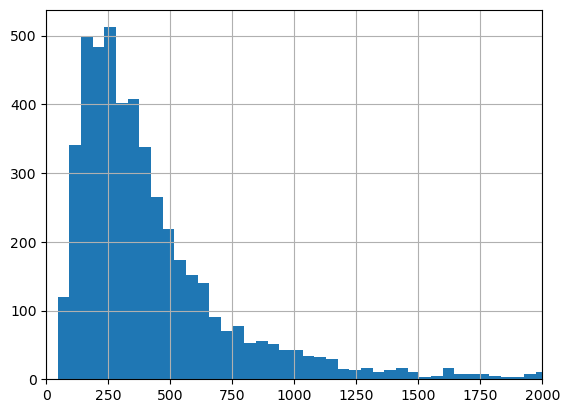

In [15]:
# Init data.
x_train_tokenized = x_train_prep.copy()
x_test_tokenized  = x_test_prep.copy()

# Create tokenizer.
from transformers import AutoTokenizer
checkpoint = checkpoints['distilbert']
tokenizer  = AutoTokenizer.from_pretrained(checkpoint)

# First, tokenize without padding and truncation.
tokenized = tokenizer(
    list(x_train_tokenized['txt_merged']), 
    padding=False,
    truncation=False,  
    return_tensors="np"  
)

# Histogram - Token Length.
x_train_tokenized['input_ids']    = list(tokenized['input_ids'])
x_train_tokenized['token_length'] = x_train_tokenized['input_ids'].apply(len)
x_train_tokenized['token_length'].hist(bins=200).set_xlim(0, 2000)              

In [16]:
# How many tokens are covered, i.e. not truncated, with the given length?
n_train       = len(x_train_tokenized['token_length'])
token_lengths = [128, 256, 512]   

for token_length in token_lengths:
    rank         = (x_train_tokenized['token_length'] <= token_length).sum()
    quantile     = (rank / n_train) * 100
    print(f"max_length={token_length} covers {quantile:.2f}% of samples!")

# Final value for max_length = 512, which is the maximum num of tokens for many LLMs.
max_length = 512

max_length=128 covers 6.97% of samples!
max_length=256 covers 34.51% of samples!
max_length=512 covers 73.39% of samples!


## 3.3. Tokenize.

In [17]:
# Simple method for tokenization.
def tokenize(df):  
    # Define Tokenizer.                   
    tokenized = tokenizer(
        list(df['txt_merged']),
        padding          = True,
        truncation       = True,
        max_length       = max_length,
#       stride           = 0,                 # Can be kept if you want overlapping tokens.
        return_tensors   = "np"  
    )

    # Tokenize.
    df['input_ids']      = list(tokenized['input_ids'])
    df['attention_mask'] = list(tokenized['attention_mask'])
    
    df = df.drop(columns=['txt_merged'])      # Drop original text column.
    
    return df

# Tokenize.
x_train_tokenized = tokenize(x_train_prep)
x_test_tokenized  = tokenize(x_test_prep)

> #### Note) `stride` for truncated tokens.  
> As you can see, 73.39% of tokens will be truncated even with `max_length=512`.  
> `max_length=512` is the most popular size for pretrained LLMs, so it's probably not enough just considering other LLMs.  
> Consider `stride` instead. It's omitted in this project because of resource.

# 4. Model.
- **Transformer** : takes input_ids and attention_mask => outputs representation.
- **Head** : takes representation from transformer AND other features (category and host) => outputs values of 30 labels.

In [18]:
# Define Custom Model.
import torch
import torch.nn as nn
from transformers import AutoModel

class CustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels, additional_feature_dim):
        super(CustomModel, self).__init__()
        
        # Load pretrained transformer.
        self.transformer = AutoModel.from_pretrained(checkpoint)

        # Expose the transformer's config.
        self.config = self.transformer.config
        
        # Combine transformer outputs with additional features
        transformer_hidden_size = self.transformer.config.hidden_size
        self.fc1 = nn.Linear(transformer_hidden_size + additional_feature_dim, num_labels)
        
#       self.fc2 = nn.Linear(256, num_labels)   # For complex Head.
#       self.dropout = nn.Dropout(0.1)          # For dropout.
        
    def forward(self, input_ids, attention_mask, additional_features):
        # Transformer output.
        transformer_output = self.transformer(
            input_ids      = input_ids,
            attention_mask = attention_mask
        )
        
        # Use [CLS] token for concatenation.
        cls_output     = transformer_output.last_hidden_state[:, 0, :]
        combined_input = torch.cat([cls_output, additional_features], dim=1)
        
        # Pass through fully connected layers
#       x = self.dropout(torch.relu(self.fc1(combined_input)))
        output = self.fc1(combined_input)
        
        return output

In [17]:
# Define HF Wrapper for Custom Model.
class HuggingFaceModelWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model         # Custom model.
        self.config     = base_model.config  # Expose the base model's config.

    def forward(self, input_ids, attention_mask, additional_features, labels=None):
        # Forward pass through the base model.
        output = self.base_model(input_ids           = input_ids, 
                                 attention_mask      = attention_mask, 
                                 additional_features = additional_features)
        
        # If labels are provided, calculate loss.
        logits = output
        loss   = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss    = loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}

    def prepare_inputs_for_generation(self, *args, **kwargs):
        # Delegate to the base model.
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)

# 5. Fine-Tuning.

## 5.1. Evaluation Metrics : Spearman's Rank Correlation Analysis.

In [18]:
from scipy.stats import spearmanr

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions    = np.argmax(logits, axis=1) if logits.ndim == 3 else logits

    # Calculate Spearman's correlation for each label.
    spearman_corrs = []
    for i in range(labels.shape[1]):
        corr, _ = spearmanr(predictions[:, i], labels[:, i])
        spearman_corrs.append(corr)

    # Return the mean of Spearman's correlation.
    mean_spearman = np.nanmean(spearman_corrs)  # Handle NaNs if any.
    return {"spearman": mean_spearman}

## 5.2. Convert Dataset, `df` -> `ds`.

In [19]:
from datasets import Dataset

def preprocess_data(df, labels):
    return {
        "input_ids"             : list(df['input_ids']),
        "attention_mask"        : list(df['attention_mask']),
        "additional_features"   : df.iloc[:, :-2].values.tolist(),  
        "labels"                : labels.to_numpy().tolist()        
    }

# Convert train and test datasets
train_dataset = Dataset.from_dict(preprocess_data(x_train_tokenized, y_train))
test_dataset  = Dataset.from_dict(preprocess_data(x_test_tokenized, y_test))

## 5.3. Train.

In [20]:
# Initialize the model.
checkpoint = checkpoints['bert']     # Other candidates : 'distilbert', 'roberta'.

num_labels              = 30
additional_features_dim = len(x_train_tokenized.columns) - 2    # Except 'input_ids' and 'attention_mask'.

model = HuggingFaceModelWrapper(
    base_model=CustomModel(checkpoint, num_labels, additional_features_dim))

# Define Callbacks.
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience  = 3,     # Stop after this consecutive non-improving eval steps
    early_stopping_threshold = 1e-5   # Minimum improvement threshold
)

# Define TrainingArguments.
from transformers import AutoModel, TrainingArguments, Trainer

# Hyperparameters.
batch_size    = 8
gra_steps     = 1
eval_steps    = 100
warmup_steps  = 0
logging_steps = 100

training_args = TrainingArguments(
    output_dir="./results",                   # Directory for saving model checkpoints
    overwrite_output_dir=True,                # Training from scratch, not from last training
    optim="adamw_bnb_8bit",                   # 8-bits Quantization of Optimizer.
    eval_strategy="steps",                    # Evaluate every few steps
    eval_steps=eval_steps,                    # Evaluation interval
    logging_dir="./logs",                     # Directory for TensorBoard logs
    logging_steps=logging_steps,              # Logging interval
    per_device_train_batch_size=batch_size,   # Batch size for training
    per_device_eval_batch_size=batch_size,    # Batch size for evaluation
    gradient_accumulation_steps=gra_steps,    # Steps for gradient accumulation
    lr_scheduler_type="linear",               # Learning scheduling: "linear"
    warmup_steps=warmup_steps,                # Warmup steps: 150. 
    weight_decay=2e-2,                        # Weight decay
    save_strategy="steps",                    # Save model checkpoints periodically
    save_steps=500,                           # Save every 500 steps
    save_total_limit=3,                       # Keep the last 3 checkpoints
    fp16=True,                                # Enable mixed precision (if supported)
    load_best_model_at_end=True,              # Load the best model after training
    metric_for_best_model="eval_spearman",    # Use Spearman for metric for this competition.
    greater_is_better=True,                   # Greater is better for Spearman.
    seed=42
)

In [259]:
%%time

# Define Trainer and train.

# Full-Training.
training_args.num_train_epochs = 10
training_args.learning_rate    = 4e-5
trainer_full = Trainer(
    model            = model,                          
    args             = training_args,              # TrainingArguments.
    train_dataset    = train_dataset,              # Training dataset.
    eval_dataset     = test_dataset,               # Validation dataset.
    processing_class = tokenizer,                  # Tokenizer.
    compute_metrics  = compute_metrics,            # Spearsman.
    callbacks        = [early_stopping_callback]   # EarlyStopping callback.
)
trainer_full.train()

# Freeze Body.
for param in model.base_model.transformer.parameters():
    param.requires_grad = False

# Head-only Training.
training_args.num_train_epochs = 20
training_args.learning_rate    = 3e-5
trainer_head = Trainer(
    model=model,                          
    args=training_args,                   # TrainingArguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=test_dataset,            # Validation dataset
    processing_class=tokenizer,           # Tokenizer
    compute_metrics=compute_metrics,      # Evaluation metric function
    callbacks=[early_stopping_callback]   # EarlyStopping Callback.
)
trainer_head.train()

# Notification for finish.
# import winsound
# winsound.PlaySound("Alarm03", winsound.SND_ALIAS)

Step,Training Loss,Validation Loss,Spearman
100,0.442400,0.426054,0.078708
200,0.428000,0.420127,0.135391
300,0.414400,0.423812,0.147738
400,0.417900,0.413562,0.192561
500,0.414500,0.408477,0.210495
600,0.406800,0.413362,0.208077
700,0.406300,0.406422,0.214082
800,0.408200,0.412028,0.217802
900,0.401000,0.405539,0.221833
1000,0.402600,0.403151,0.228792


Could not locate the best model at ./results\checkpoint-1400\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Step,Training Loss,Validation Loss,Spearman
100,0.392000,0.399462,0.247460
200,0.395700,0.398877,0.250791
300,0.386500,0.398543,0.252654


KeyboardInterrupt: 

In [ ]:
# Check rank.
history  = trainer_head.state.log_history   # Check `trainer_head` or `trainer_full`.
my_score = max(
    log["eval_spearman"] for log in history if "eval_spearman" in log
)
check_rank(my_score)

plot_learning_curve(trainer_full.state.log_history)
plot_learning_curve(trainer_head.state.log_history)

### DistilBERT.
| Parameter                 | Value                   |
|---------------------------|-------------------------|
| Model                     | distilbert-base-uncased |
| Max Length                | 512                     |
| Learning Rate (Full)      | 4e-5                    |
| Learning Rate (Head)      | 3e-5                    |
| Weight Decay              | 2e-2                    |
| Warmup Steps              | 0                       |
| Batch Size                | 8                       |
| Gradient Accumulation     | 1                       |
| Evaluation Steps          | 100                     |
| Early Stopping Patience   | 3                       |
| Early Stopping Threshold  | 1e-5                    |
| Full Fine-Tuning Epochs   | 10      |
| Head Fine-Tuning Epochs   | 20       |
| Spearman Correlation      | 0.3783                  |
| CPU Time                  | 7min 11s               |
| Wall Time                 | 5min 50s               |
| Train Runtime             | 111.5316 seconds        |
| Train Samples Per Second  | 872.04                 |
| Train Steps Per Second    | 109.027                |


### BERT.

| Parameter                   | Value                   |
|-----------------------------|-------------------------|
| Model                       | bert-base-uncased       |
| Max Length                  | 512                     |
| Learning Rate (Full)        | 4e-5                    |
| Learning Rate (Head)        | 3e-5                    |
| Weight Decay                | 2e-2                    |
| Warmup Steps                | 0                       |
| Batch Size                  | 8                       |
| Gradient Accumulation Steps | 1                       |
| Evaluation Steps            | 100                     |
| Early Stopping Patience     | 3                       |
| Early Stopping Threshold    | 1e-5                    |
| Full Fine-Tuning Epochs     | 10      |
| Head Fine-Tuning Epochs     | 20                      |
| Spearman Correlation        | 0.3813 (127 / 1572)     |
| CPU Time                    | 10min 32s              |
| Wall Time                   | 9min 26s               |
| Train Runtime               | 125.9416 seconds        |
| Train Samples Per Second    | 772.262                |
| Train Steps Per Second      | 96.553                 |
| Training Loss               | 0.324978                |
| Global Steps                | 1200                   |


# 6. Summary.

In [ ]:
# Load.
from sklearn.model_selection import train_test_split
data                = pd.read_csv('./dataset/train.csv')
train_set, test_set = train_test_split(data, test_size=0.2)

# Train-Test Split.
label_col_idx = train_set.columns.get_loc('question_asker_intent_understanding')  # Label Columns start from it.
x_train       = train_set.iloc[:, :label_col_idx]
y_train       = train_set.iloc[:, label_col_idx:]
x_test        = test_set.iloc[:, :label_col_idx]
y_test        = test_set.iloc[:, label_col_idx:]

# Preprocessing.
from sklearn.preprocessing import OneHotEncoder

def preprocess(x_train, n_hosts=10):
    # 2.2.1. Drop redundant features.
    redundant_features   = ['qa_id', 'question_user_name', 'question_user_page', 
                            'answer_user_page', 'answer_user_name', 'url']
    x_train = x_train.drop(columns=redundant_features)

    # 2.2.2. Encode categorical features.
    # Converts other categories into 'Others'.
    top_hosts = x_train['host'].value_counts().nlargest(n_hosts).index
    x_train['host'] = x_train['host'].apply(lambda x: x if x in top_hosts else 'Others')

    # Encode `category` and `host`.
    categorical_features = ['category', 'host']
    one_enc     = OneHotEncoder(handle_unknown='ignore')    # Zero vector for unknown category.
    x_enc       = one_enc.fit_transform(x_train[categorical_features])

    # Convert back to DataFrame.
    enc_columns = one_enc.get_feature_names_out(categorical_features)
    x_enc_df    = pd.DataFrame(x_enc.toarray(), columns=enc_columns, index=x_train.index)
    x_train     = x_train.drop(columns=categorical_features)   # Drop original 'category' and 'host' columns.
    x_train     = pd.concat([x_train, x_enc_df], axis=1)       # Concatenate the encoded columns back.

    # 2.2.3. Merge txt columns.
    cols_txt = ['question_title', 'question_body', 'answer']
    x_train['txt_merged'] = x_train[cols_txt].apply(lambda row: ' '.join(row), axis=1)
    x_train  = x_train.drop(columns=cols_txt)    # Drop original txt cols.
    
    # Return.
    return x_train

x_train_prep = preprocess(x_train, n_hosts=10)
x_test_prep  = preprocess(x_test, n_hosts=10)

# Tokenize.
def tokenize(df):  
    # Define Tokenizer.                   
    tokenized = tokenizer(
        list(df['txt_merged']),
        padding          = True,
        truncation       = True,
        max_length       = max_length,
#       stride           = 0,                 # Can be kept if you want overlapping tokens.
        return_tensors   = "np"  
    )

    df['input_ids']      = list(tokenized['input_ids'])
    df['attention_mask'] = list(tokenized['attention_mask'])
    
    df = df.drop(columns=['txt_merged'])      # Drop original text column.
    
    return df

x_train_tokenized = tokenize(x_train_prep)
x_test_tokenized  = tokenize(x_test_prep)

# Convert datasets, `df` -> `ds`.
from datasets import Dataset

train_dataset = Dataset.from_dict(preprocess_data(x_train_tokenized, y_train))
test_dataset  = Dataset.from_dict(preprocess_data(x_test_tokenized, y_test))

In [ ]:
# Train.

# Initialize the model.
checkpoint = checkpoints['bert']     # Other candidates : 'distilbert', 'roberta'.

num_labels              = 30
additional_features_dim = len(x_train_tokenized.columns) - 2    # Except 'input_ids' and 'attention_mask'.

model = HuggingFaceModelWrapper(
    base_model=CustomModel(checkpoint, num_labels, additional_features_dim))

# Define Callbacks.
from transformers import EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience  = 3,     # Stop after this consecutive non-improving eval steps
    early_stopping_threshold = 1e-5   # Minimum improvement threshold
)

# Define TrainingArguments.
from transformers import AutoModel, TrainingArguments, Trainer

# Hyperparameters.
batch_size    = 8
gra_steps     = 1
eval_steps    = 100
warmup_steps  = 0
logging_steps = 100

training_args = TrainingArguments(
    output_dir="./results",                   # Directory for saving model checkpoints
    overwrite_output_dir=True,                # Training from scratch, not from last training
    optim="adamw_bnb_8bit",                   # 8-bits Quantization of Optimizer.
    eval_strategy="steps",                    # Evaluate every few steps
    eval_steps=eval_steps,                    # Evaluation interval
    logging_dir="./logs",                     # Directory for TensorBoard logs
    logging_steps=logging_steps,              # Logging interval
    per_device_train_batch_size=batch_size,   # Batch size for training
    per_device_eval_batch_size=batch_size,    # Batch size for evaluation
    gradient_accumulation_steps=gra_steps,    # Steps for gradient accumulation
    lr_scheduler_type="linear",               # Learning scheduling: "linear"
    warmup_steps=warmup_steps,                # Warmup steps: 150. 
    weight_decay=2e-2,                        # Weight decay
    save_strategy="steps",                    # Save model checkpoints periodically
    save_steps=500,                           # Save every 500 steps
    save_total_limit=3,                       # Keep the last 3 checkpoints
    fp16=True,                                # Enable mixed precision (if supported)
    load_best_model_at_end=True,              # Load the best model after training
    metric_for_best_model="eval_spearman",    # Use Spearman for metric for this competition.
    greater_is_better=True,                   # Greater is better for Spearman.
    seed=42
)

In [ ]:
%%time

# Define Trainer and train.

# Full-Training.
training_args.num_train_epochs = 10
training_args.learning_rate    = 4e-5
trainer_full = Trainer(
    model            = model,                          
    args             = training_args,              # TrainingArguments.
    train_dataset    = train_dataset,              # Training dataset.
    eval_dataset     = test_dataset,               # Validation dataset.
    processing_class = tokenizer,                  # Tokenizer.
    compute_metrics  = compute_metrics,            # Spearsman.
    callbacks        = [early_stopping_callback]   # EarlyStopping callback.
)
trainer_full.train()

# Freeze Body.
for param in model.base_model.transformer.parameters():
    param.requires_grad = False

# Head-only Training.
training_args.num_train_epochs = 20
training_args.learning_rate    = 3e-5
trainer_head = Trainer(
    model=model,                          
    args=training_args,                   # TrainingArguments
    train_dataset=train_dataset,          # Training dataset
    eval_dataset=test_dataset,            # Validation dataset
    processing_class=tokenizer,           # Tokenizer
    compute_metrics=compute_metrics,      # Evaluation metric function
    callbacks=[early_stopping_callback]   # EarlyStopping Callback.
)
trainer_head.train()

# Notification for finish.
# import winsound
# winsound.PlaySound("Alarm03", winsound.SND_ALIAS)

In [ ]:
# Defines.

# Define Custom Model.
import torch
import torch.nn as nn
from transformers import AutoModel

class CustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels, additional_feature_dim):
        super(CustomModel, self).__init__()
        
        # Load pretrained transformer.
        self.transformer = AutoModel.from_pretrained(checkpoint)

        # Expose the transformer's config.
        self.config = self.transformer.config
        
        # Combine transformer outputs with additional features
        transformer_hidden_size = self.transformer.config.hidden_size
        self.fc1 = nn.Linear(transformer_hidden_size + additional_feature_dim, num_labels)
        
#       self.fc2 = nn.Linear(256, num_labels)   # For complex Head.
#       self.dropout = nn.Dropout(0.1)          # For dropout.
        
    def forward(self, input_ids, attention_mask, additional_features):
        # Transformer output.
        transformer_output = self.transformer(
            input_ids      = input_ids,
            attention_mask = attention_mask
        )
        
        # Use [CLS] token for concatenation.
        cls_output     = transformer_output.last_hidden_state[:, 0, :]
        combined_input = torch.cat([cls_output, additional_features], dim=1)
        
        # Pass through fully connected layers
#       x = self.dropout(torch.relu(self.fc1(combined_input)))
        output = self.fc1(combined_input)
        
        return output

# Define HF Wrapper for Custom Model.
class HuggingFaceModelWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model         # Custom model.
        self.config     = base_model.config  # Expose the base model's config.

    def forward(self, input_ids, attention_mask, additional_features, labels=None):
        # Forward pass through the base model.
        output = self.base_model(input_ids           = input_ids, 
                                 attention_mask      = attention_mask, 
                                 additional_features = additional_features)
        
        # If labels are provided, calculate loss.
        logits = output
        loss   = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss    = loss_fn(logits, labels)
        
        return {"loss": loss, "logits": logits}

    def prepare_inputs_for_generation(self, *args, **kwargs):
        # Delegate to the base model.
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)

# Spearman's Corr.
from scipy.stats import spearmanr

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions    = np.argmax(logits, axis=1) if logits.ndim == 3 else logits

    # Calculate Spearman's correlation for each label.
    spearman_corrs = []
    for i in range(labels.shape[1]):
        corr, _ = spearmanr(predictions[:, i], labels[:, i])
        spearman_corrs.append(corr)

    # Return the mean of Spearman's correlation.
    mean_spearman = np.nanmean(spearman_corrs)  # Handle NaNs if any.
    return {"spearman": mean_spearman}

# Convert datasets, `df` -> `ds`.
def preprocess_data(df, labels):
    return {
        "input_ids"             : list(df['input_ids']),
        "attention_mask"        : list(df['attention_mask']),
        "additional_features"   : df.iloc[:, :-2].values.tolist(),  
        "labels"                : labels.to_numpy().tolist()        
    }

# Method to Check Rank.
def check_rank(score):
    leaderboard = pd.read_csv('./leaderboard.csv')
    num_team    = len(leaderboard)
    mean        = leaderboard['Score'].mean()
    median      = leaderboard['Score'].median()

    my_rank = (leaderboard['Score'] >= my_score).sum()

    print(f'My Rank = {my_rank} / {num_team}')
    print(f'My Score = {score:.4f}')
    print(f'Mean = {mean:.4f}')
    print(f'Median = {median:.4f}')

# Plot Learning Curve.
def plot_learning_curve(history):
    eval_loss  = [log["eval_loss"] for log in history if "eval_loss" in log]
    train_loss = [log["loss"] for log in history if "loss" in log]
    spear_loss = [log["eval_spearman"] for log in history if "loss" in log]
    
    plt.figure(figsize=(10, 6))
    
    # Training Loss curve
    plt.plot(
        [log["step"] for log in history if "loss" in log],
        train_loss,
        label="Training Loss",
        marker="o",
    )
    
    # Validation Loss curve
    plt.plot(
        [log["step"] for log in history if "eval_loss" in log],
        eval_loss,
        label="Validation Loss",
        marker="x",
    )

    # Spearman Loss curve
    plt.plot(
        [log["step"] for log in history if "eval_loss" in log],
        spear_loss,
        label="Spearman Loss",
        marker="x",
    )
    
    # Labels and legends
    plt.title("Training and Validation Loss Curve")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()